# 1.Imports and device setup

In [50]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import random_split, DataLoader

import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check PyTorch and torchvision versions
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Torch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
Device: cuda:0


#### Unzip Datasets(in G.Drive): image_train, image_test

In [51]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# UNZIPPING THE DATASETS
with zipfile.ZipFile('/content/drive/MyDrive/finetuning/images_training_rev1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/image_train')

# Path to the main zip file
zip_file_path = '/content/drive/MyDrive/finetuning/images_test_rev1.zip'
output_dir = '/content/image_test'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to recursively unzip files
def unzip_all(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        for root, _, files in os.walk(extract_to):
            for file in files:
                if file.endswith('.zip'):
                    nested_zip_path = os.path.join(root, file)
                    nested_output_dir = os.path.join(root, file.replace('.zip', ''))
                    os.makedirs(nested_output_dir, exist_ok=True)
                    unzip_all(nested_zip_path, nested_output_dir)  # Recursively unzip nested zip files
                    os.remove(nested_zip_path)  # Optionally remove nested zip file after extraction

# Unzip the main file and handle nested zips
unzip_all(zip_file_path, output_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Organize unzipped files

In [52]:
# LOADING IMAGE PATH IMAGES AND LABELS
image_dir = '/content/image_train/images_training_rev1'  # Path to training images
labels_path = '/content/training_solutions_rev1.csv'  # Path to labels CSV

# Load labels
labels_df = pd.read_csv(labels_path)
print("Labels loaded:", labels_df.shape)

Labels loaded: (61578, 38)


In [53]:
print(labels_df.head())

   GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0    100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1    100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2    100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3    100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4    100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1  0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2  0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3  0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  Class11.6  
0   0.000000   0.000000   0.092886 

# 2.PreProcessing Data

In [54]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [55]:

#CUSTOM DTASET CLASS(GALAXY DATASET)
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Assuming the image filename is in the first column
        img_filename = str(self.labels_df.iloc[idx, 0]) + '.jpg'  # Add .jpg extension if needed
        img_name = os.path.join(self.image_dir, img_filename)  # Adjust if there's a different file extension

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Image file not found: {img_name}")
            raise

        label = torch.tensor(self.labels_df.iloc[idx, 1:].values, dtype=torch.float32)  # labels as tensor
        if self.transform:
            image = self.transform(image)

        return image, label



#### Splitting the Dataset

In [56]:
# Define the dataset
dataset = GalaxyDataset(image_dir, labels_df, transform=transform)

# Splitting the dataset into train, validation, and test sets
batch_size = 37  # Batch size for data loading
# Load central_pixel_benchmark to get test GalaxyIDs
benchmark_ids = pd.read_csv("central_pixel_benchmark.csv")["GalaxyID"]

# Filter the dataset for matching GalaxyIDs
test_indices = labels_df[labels_df["GalaxyID"].isin(benchmark_ids)].index
train_val_indices = labels_df[~labels_df["GalaxyID"].isin(benchmark_ids)].index

# Re-split train and validation from the remaining data
train_size = int(0.7 * len(train_val_indices))
valid_size = int(0.15 * len(dataset))
test_size = int(len(dataset) )- train_size - valid_size


train_indices = train_val_indices[:train_size]
val_indices = train_val_indices[train_size:]

# Subset datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [58]:
# Check the shape of a batch from the train loader
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
print("Train batch shape:", images.shape)
print("Train labels batch shape:", labels.shape)

# Check the shape of a batch from the validation loader
dataiter_valid = iter(validloader)
images_valid, labels_valid = next(dataiter_valid)
print("Validation batch shape:", images_valid.shape)
print("Validation labels batch shape:", labels_valid.shape)



Train batch shape: torch.Size([37, 3, 224, 224])
Train labels batch shape: torch.Size([37, 37])
Validation batch shape: torch.Size([37, 3, 224, 224])
Validation labels batch shape: torch.Size([37, 37])


In [59]:
# Check the shape of a batch from the test loader
dataiter_test = iter(testloader)
images_test, labels_test = next(dataiter_test)
print("Test batch shape:", images_test.shape)
print("Test labels batch shape:", labels_test.shape)


StopIteration: 

In [43]:
print(labels_df.head())  # Check if GalaxyIDs align with the benchmark file
print(benchmark_ids.head())  # Ensure GalaxyIDs are correctly loaded


   GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0    100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1    100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2    100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3    100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4    100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1  0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2  0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3  0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  Class11.6  
0   0.000000   0.000000   0.092886 

In [45]:
print(labels_df.head())

   GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0    100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1    100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2    100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3    100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4    100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1  0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2  0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3  0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  Class11.6  
0   0.000000   0.000000   0.092886 

In [44]:
print(benchmark_ids.head())

0    100018
1    100037
2    100042
3    100052
4    100056
Name: GalaxyID, dtype: int64


#### Visualize training dataset

In [30]:
# Visualizing a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Fetch the first batch of training images
print("Train batch shape:", images.shape)
print("Train labels batch shape:", labels.shape)

Train batch shape: torch.Size([37, 3, 224, 224])
Train labels batch shape: torch.Size([37, 37])


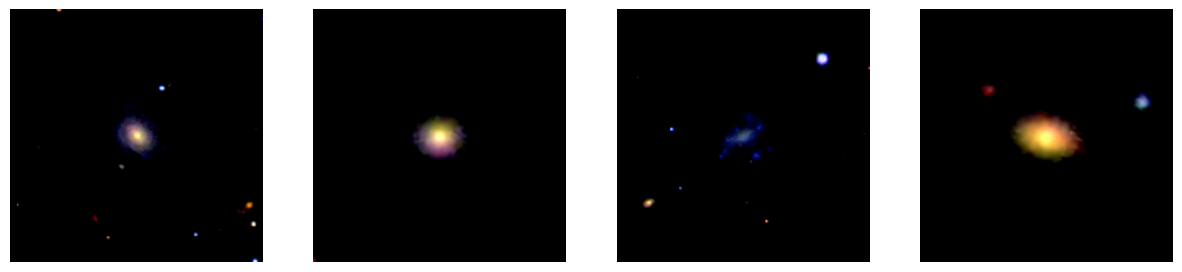

In [31]:
# Example of visualizing images from the train dataset
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):  # Display 4 images
    ax[i].imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize for visualization
    ax[i].axis('off')
plt.show()

# 3.Load Pre-Trained ResNet-50

In [32]:
from torchvision.models import resnet50, ResNet50_Weights

# Load pre-trained ResNet-50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the final layer to match the number of output classes
num_classes = labels_df.shape[1] - 1  # Exclude the image filename column
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the device
model = model.to(device)
print("Model loaded and moved to device.")


Model loaded and moved to device.


In [39]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Placeholder for predictions

galaxy_ids = []  # To store Galaxy IDs

all_preds = []   # To store predictions (probabilities for each class)



# Evaluate on the test set

with torch.no_grad():

    for batch_idx, (inputs, _) in tqdm(enumerate(testloader), total=len(testloader)):

        inputs = inputs.to(device)



        # Forward pass

        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)  # Apply softmax for probabilities



        # Map the indices back to the original dataset

        subset_indices = test_dataset.indices

        original_indices = subset_indices[batch_idx * batch_size: (batch_idx + 1) * batch_size]

        filenames = [dataset.labels_df.iloc[idx, 0] for idx in original_indices]



        # Store galaxy IDs (from filenames) and predictions

        galaxy_ids.extend(filenames)

        all_preds.extend(probs.cpu().numpy())

0it [00:00, ?it/s]


In [40]:
print(f"Test dataset size: {len(test_dataset)}")
print(f"Test loader batches: {len(testloader)}")


Test dataset size: 0
Test loader batches: 0


In [34]:
pip install tqdm

In [35]:
# Checking the shape of all_preds
print(np.array(all_preds).shape)  # Should show (number of samples, 37)

# If you're using a PyTorch tensor
print(torch.tensor(all_preds).shape)  # Should show (number of samples, 37)

(0,)
torch.Size([0])


In [36]:
print(labels_df.columns)

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')


In [1]:
print(all_preds.shape)
print(all_preds)


NameError: name 'all_preds' is not defined

In [37]:
# Ensure labels are numerical
labels_df.iloc[:, 1:] = labels_df.iloc[:, 1:].astype(float)

# Extract true labels for test dataset
all_labels = labels_df.iloc[test_dataset.indices, 1:].values

# Convert all_preds to a NumPy array
all_preds = np.array(all_preds)

# Ensure shape consistency
if all_preds.shape != all_labels.shape:
    print(f"Shape mismatch: all_preds={all_preds.shape}, all_labels={all_labels.shape}")
else:
    # Calculate RMSE
    rmse = np.sqrt(np.mean((all_preds - all_labels) ** 2))
    print("RMSE on test set:", rmse)



Shape mismatch: all_preds=(0,), all_labels=(0, 37)


In [38]:
# Save predictions for submission
submission = pd.DataFrame(all_preds, columns=[
    'Class1.1', 'Class1.2', 'Class1.3',  # Question 1
    'Class2.1', 'Class2.2',              # Question 2
    'Class3.1', 'Class3.2',              # Question 3
    'Class4.1', 'Class4.2',              # Question 4
    'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4',  # Question 5
    'Class6.1', 'Class6.2',              # Question 6
    'Class7.1', 'Class7.2', 'Class7.3',  # Question 7
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7',  # Question 8
    'Class9.1', 'Class9.2', 'Class9.3',  # Question 9
    'Class10.1', 'Class10.2', 'Class10.3',  # Question 10
    'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6'  # Question 11  # Continue with all 37 classes
    # Add column names here corresponding to your GalaxyZoo classes
])
submission.insert(0, "GalaxyID", pd.read_csv(labels_path)["GalaxyID"])
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

ValueError: Shape of passed values is (0, 1), indices imply (0, 37)

In [ ]:
# Convert predictions to class indices
predicted_classes = np.argmax(all_preds, axis=1)

# Convert true labels to class indices
true_classes = np.argmax(all_labels, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")

In [ ]:
from google.colab import files

# Download the CSV file
files.download("submission.csv")

In [ ]:
import pandas as pd
import numpy as np

# Load reference and submission files
reference = pd.read_csv('central_pixel_benchmark.csv')
submission = pd.read_csv('submission.csv')

# Check if files are loaded correctly
print("Reference file shape:", reference.shape)
print("Submission file shape:", submission.shape)

# Check for matching GalaxyIDs
merged = reference.merge(submission, on="GalaxyID", suffixes=("_true", "_pred"))
print("Merged file shape:", merged.shape)

# If merged is empty, check for mismatches
if merged.empty:
    print("No matching GalaxyIDs found. Verify the IDs in both files.")
else:
    # Calculate accuracy
    correct = 0
    total = len(merged)

    for _, row in merged.iterrows():
        true_label = np.argmax(row.filter(like="_true").values)
        pred_label = np.argmax(row.filter(like="_pred").values)
        if true_label == pred_label:
            correct += 1

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")



In [ ]:
print(reference['GalaxyID'].dtype)
print(submission['GalaxyID'].dtype)


In [ ]:
print("Reference GalaxyIDs:", reference['GalaxyID'].head())
print("Submission GalaxyIDs:", submission['GalaxyID'].head())


In [ ]:
print("Reference GalaxyID range:", reference['GalaxyID'].min(), "-", reference['GalaxyID'].max())
print("Submission GalaxyID range:", submission['GalaxyID'].min(), "-", submission['GalaxyID'].max())


In [ ]:
common_ids = set(reference['GalaxyID']).intersection(set(submission['GalaxyID']))
print("Number of matching GalaxyIDs:", len(common_ids))


In [ ]:
missing_in_submission = set(reference['GalaxyID']) - set(submission['GalaxyID'])
missing_in_reference = set(submission['GalaxyID']) - set(reference['GalaxyID'])

print("Number of IDs missing in submission:", len(missing_in_submission))
print("Number of IDs missing in reference:", len(missing_in_reference))
